In [270]:
import pandas as pd
import numpy as np
import json
import os
from jsonpath_ng import parse as j_parse

    Recursion function to get file paths

In [271]:
def get_paths(path, depth=1,):
    paths = []
    def aggregateFolder(path, depth=1,):
        if depth:
            for name in os.listdir(path):
                n_path = f"{path}/{name}"
                aggregateFolder(n_path, depth-1)
        elif depth == 0:
            paths.append(path)
        return
    aggregateFolder(path, 3)
    return paths


In [272]:
def get_path_vals(path,slice_=[None],split_c='/'):
    return path.split(split_c)[slice(*slice_)]

    Dict that describes the data extraction from files

In [273]:
df_data_paths = \
    {
        "path": "./data",
        "f_path": "/country/india/state",
        "path_fields": ["state", "year", "quarter"],
        "aggregated": {
            "path": lambda: df_data_paths['path']+"/aggregated",
            "transaction": {
                "path": lambda: df_data_paths['aggregated']['path']()
                + "/transaction"+df_data_paths['f_path'],
                "row_path": '["data"]["transactionData"]',
                "fields": {"type": '["name"]',
                            "count": '["paymentInstruments"][0]["count"]',
                           "amount": '["paymentInstruments"][0]["amount"]'}
            },
            "user": {
                "path": lambda: df_data_paths['aggregated']['path']()
                + "/user"+df_data_paths['f_path'],
                "row_path": '["data"]["usersByDevice"]',
                "fields": {"brand": '["brand"]',
                           "count": '["count"]',
                           "percentage": '["percentage"]'}
            }
        },
        "map": {
            "path": lambda: df_data_paths['path']+"/map",
            "transaction": {
                "path": lambda: df_data_paths['map']['path']()
                + "/transaction/hover"+df_data_paths['f_path'],
                "row_path": '["data"]["hoverDataList"]',
                "fields": {"district": '["name"]',
                            "count": '["metric"][0]["count"]',
                            "amount": '["metric"][0]["amount"]'}
            },
            "user": {
                "path": lambda: df_data_paths['map']['path']()
                + "/user/hover"+df_data_paths['f_path'],
                "row_path": '["data"]["hoverData"]',
                "fields": {"district": '["id"]',
                            "registeredUsers": '[*]["registeredUsers"]',
                            "appOpens": '[*]["appOpens"]'}
            }
        },
        "top": {
            "path": lambda: df_data_paths['path']+"/top",
            "transaction": {
                "path": lambda: df_data_paths['top']['path']()
                + "/transaction"+df_data_paths['f_path'],
                "row_path": '["data"]["pincodes"]',
                "fields": {"pincode": '["entityName"]',
                            "count": '["metric"]["count"]',
                            "amount": '["metric"]["amount"]'}
            },
            "user": {
                "path": lambda: df_data_paths['top']['path']()
                + "/user"+df_data_paths['f_path'],
                "row_path": '["data"]["pincodes"]',
                "fields": {"pincode": '["name"]',
                            "registeredUsers": '["registeredUsers"]',
                           }
            }
        }
    }


    Loop to extract the data to data frames

In [274]:
df_kinds = ["aggregated","map","top",]
df_sub_kinds = ["transaction","user"]

dfs = []

for kind in df_kinds:
    for sub_kind in df_sub_kinds:
        df_rows = []
        dict_ = df_data_paths[kind][sub_kind]
        file_fields = list(dict_["fields"].keys())
        df_columns = df_data_paths['path_fields']+file_fields
        base_path = dict_['path']()
        row_path = j_parse(dict_["row_path"])
        val_paths = [j_parse(val_path)
                     for val_path in dict_["fields"].values()]
        paths = get_paths(base_path, 3)
        for path in paths:
            path_vals = get_path_vals(path, [-3, None])
            json_data = None
            with open(path) as file:
                json_data = json.load(file)
            rows = row_path.find(json_data)
            for row in rows[0].value:
                if isinstance(row, str):
                    key = row
                    row = rows[0].value[key]
                    row['id'] = key
                file_fields_val = [val_path.find(row)[0].value
                                   for val_path in val_paths]
                row_ = path_vals+file_fields_val
                df_rows.append(row_)
        df = pd.DataFrame(df_rows, columns=df_columns)
        dfs.append(df)


In [275]:
df_a_t,df_a_u,df_m_t,df_m_u,df_t_t,df_t_u = dfs

In [276]:
df_a_t.head()


,state,year,quarter,type,count,amount
0,andaman-_-nicobar-islands,2019,3.json,Recharge & bill payments,16219,8.171738e+06
1,andaman-_-nicobar-islands,2019,3.json,Peer-to-peer payments,13767,1.010798e+08
2,andaman-_-nicobar-islands,2019,3.json,Merchant payments,3519,4.428735e+06
3,andaman-_-nicobar-islands,2019,3.json,Financial Services,50,1.588579e+05
4,andaman-_-nicobar-islands,2019,3.json,Others,215,2.326248e+05


In [277]:
df_a_u.head()


,state,year,quarter,brand,count,percentage
0,andaman-_-nicobar-islands,2019,3.json,Xiaomi,5819,0.243157
1,andaman-_-nicobar-islands,2019,3.json,Vivo,4685,0.195771
2,andaman-_-nicobar-islands,2019,3.json,Samsung,4508,0.188375
3,andaman-_-nicobar-islands,2019,3.json,Oppo,2108,0.088087
4,andaman-_-nicobar-islands,2019,3.json,Realme,1158,0.048389


In [278]:
df_m_t.head()


,state,year,quarter,district,count,amount
0,andaman-_-nicobar-islands,2019,3.json,north and middle andaman district,4049,1.148147e+07
1,andaman-_-nicobar-islands,2019,3.json,south andaman district,27421,9.102389e+07
2,andaman-_-nicobar-islands,2019,3.json,nicobars district,2300,1.156642e+07
3,andaman-_-nicobar-islands,2019,2.json,north and middle andaman district,3371,8.612103e+06
4,andaman-_-nicobar-islands,2019,2.json,south andaman district,28490,1.025310e+08


In [279]:
df_m_u.head()


,state,year,quarter,district,registeredUsers,appOpens
0,andaman-_-nicobar-islands,2019,3.json,north and middle andaman district,2662,22064
1,andaman-_-nicobar-islands,2019,3.json,south andaman district,20518,138190
2,andaman-_-nicobar-islands,2019,3.json,nicobars district,751,10853
3,andaman-_-nicobar-islands,2019,2.json,north and middle andaman district,2417,6118
4,andaman-_-nicobar-islands,2019,2.json,south andaman district,18621,43569


In [280]:
df_t_t.head()


,state,year,quarter,pincode,count,amount
0,andaman-_-nicobar-islands,2019,3.json,744103,5680,1.990634e+07
1,andaman-_-nicobar-islands,2019,3.json,744101,5606,1.874515e+07
2,andaman-_-nicobar-islands,2019,3.json,744104,4786,1.575479e+07
3,andaman-_-nicobar-islands,2019,3.json,744102,3643,1.457261e+07
4,andaman-_-nicobar-islands,2019,3.json,744105,3512,1.176722e+07


In [281]:
df_t_u.head()

,state,year,quarter,pincode,registeredUsers
0,andaman-_-nicobar-islands,2019,3.json,744103,5218
1,andaman-_-nicobar-islands,2019,3.json,744101,4026
2,andaman-_-nicobar-islands,2019,3.json,744105,3920
3,andaman-_-nicobar-islands,2019,3.json,744102,3250
4,andaman-_-nicobar-islands,2019,3.json,744202,982


    Merging and renaming data frames 

In [282]:
df_payment_type = df_a_t
df_payment_device = df_a_u

In [283]:
df_districts = pd.merge(df_m_t, df_m_u, on=["state",	"year",
                                           "quarter",	"district"], how='inner')


In [284]:
df_zips = pd.merge(df_t_t, df_t_u, on=["state",	"year",
                                           "quarter",	"pincode"], how='inner')


In [285]:
temp = [df_payment_type,df_payment_device,df_districts,df_zips]
quarters_map = {f"{i}.json":i for i in range(1,5)}
quarters_map

{'1.json': 1, '2.json': 2, '3.json': 3, '4.json': 4}

In [286]:
for df in temp:
    df.replace(quarters_map, inplace=True)

    Fix State Names

In [287]:
df_districts['state'].unique()

array(['andaman-_-nicobar-islands', 'bihar', 'uttar-pradesh', 'sikkim',
       'delhi', 'tripura', 'mizoram', 'kerala', 'madhya-pradesh',
       'gujarat', 'himachal-pradesh', 'rajasthan', 'goa', 'west-bengal',
       'lakshadweep', 'chhattisgarh', 'karnataka', 'maharashtra',
       'telangana', 'haryana', 'chandigarh', 'arunachal-pradesh',
       'meghalaya', 'andhra-pradesh', 'assam', 'jammu-_-kashmir',
       'ladakh', 'nagaland', 'jharkhand', 'odisha', 'puducherry',
       'uttarakhand', 'punjab', 'dadra-_-nagar-haveli-_-daman-_-diu',
       'tamil-nadu', 'manipur'], dtype=object)

In [288]:
states = \
["Andhra Pradesh",
 "Arunachal Pradesh",
 "Assam",
 "Bihar",
 "Chhattisgarh",
 "Goa",
 "Gujarat",
 "Haryana",
 "Himachal Pradesh",
 "Jharkhand",
 "Karnataka",
 "Kerala",
 "Madhya Pradesh",
 "Maharashtra",
 "Manipur",
 "Meghalaya",
 "Mizoram",
 "Nagaland",
 "Odisha",
 "Punjab",
 "Rajasthan",
 "Sikkim",
 "Tamil Nadu",
 "Telangana",
 "Tripura",
 "Uttar Pradesh",
 "Uttarakhand",
 "West Bengal",
 #
 "Andaman and Nicobar",
 "Chandigarh",
 "Daman and Diu",
 "Dadar and Nagar Haveli",
 "Delhi",
 "Jammu and Kashmir",
 "Ladakh",
 "Lakshadweep",
 "Puducherry",
 ]
len(states)

37

    Fixing Spellings

In [289]:
from fuzzywuzzy import process as fw_p


In [290]:
def extract_similar(str_list, to_match,match_percent=50):
    map_dict ={}
    for str_ in str_list:
        match = fw_p.extract(str_, to_match, limit=1)[0][0]
        map_dict[str_]=match
    return map_dict

In [291]:
map_spelling = extract_similar(df_districts['state'].unique(), states)
map_spelling

{'andaman-_-nicobar-islands': 'Andaman and Nicobar',
 'bihar': 'Bihar',
 'uttar-pradesh': 'Uttar Pradesh',
 'sikkim': 'Sikkim',
 'delhi': 'Delhi',
 'tripura': 'Tripura',
 'mizoram': 'Mizoram',
 'kerala': 'Kerala',
 'madhya-pradesh': 'Madhya Pradesh',
 'gujarat': 'Gujarat',
 'himachal-pradesh': 'Himachal Pradesh',
 'rajasthan': 'Rajasthan',
 'goa': 'Goa',
 'west-bengal': 'West Bengal',
 'lakshadweep': 'Lakshadweep',
 'chhattisgarh': 'Chhattisgarh',
 'karnataka': 'Karnataka',
 'maharashtra': 'Maharashtra',
 'telangana': 'Telangana',
 'haryana': 'Haryana',
 'chandigarh': 'Chandigarh',
 'arunachal-pradesh': 'Arunachal Pradesh',
 'meghalaya': 'Meghalaya',
 'andhra-pradesh': 'Andhra Pradesh',
 'assam': 'Assam',
 'jammu-_-kashmir': 'Jammu and Kashmir',
 'ladakh': 'Ladakh',
 'nagaland': 'Nagaland',
 'jharkhand': 'Jharkhand',
 'odisha': 'Odisha',
 'puducherry': 'Puducherry',
 'uttarakhand': 'Uttarakhand',
 'punjab': 'Punjab',
 'dadra-_-nagar-haveli-_-daman-_-diu': 'Daman and Diu',
 'tamil-nadu'

In [292]:

temp = [df_payment_type, df_payment_device, df_districts, df_zips]
for df in temp:
    df.replace({"state": map_spelling}, inplace=True)


In [293]:
for df in temp:
    print(df.isnull().sum())
    print(df.shape)

state      0
year       0
quarter    0
type       0
count      0
amount     0
dtype: int64
(3054, 6)
state         0
year          0
quarter       0
brand         0
count         0
percentage    0
dtype: int64
(6732, 6)
state              0
year               0
quarter            0
district           0
count              0
amount             0
registeredUsers    0
appOpens           0
dtype: int64
(12440, 8)
state              0
year               0
quarter            0
pincode            0
count              0
amount             0
registeredUsers    0
dtype: int64
(4384, 7)


    Adding Latitude and Longitude

In [294]:
import pgeocode
nomi = pgeocode.Nominatim('in')
pincode_lat={}
pincode_long={}
for pincode in df_zips["pincode"].unique():
    data = nomi.query_postal_code(pincode)
    pincode_lat[pincode] = data['latitude']
    pincode_long[pincode] = data['longitude']
# pincode_lat,pincode_long

In [295]:
df_zips['longitude'] = df_zips['pincode']
df_zips['latitude'] = df_zips['pincode']
df_zips.replace({'longitude':pincode_long}, inplace=True)
df_zips.replace({'latitude':pincode_lat}, inplace=True)
df_zips.head()

,state,year,quarter,pincode,count,amount,registeredUsers,longitude,latitude
0,Andaman and Nicobar,2019,3,744103,5680,1.990634e+07,5218,92.6167,11.7167
1,Andaman and Nicobar,2019,3,744101,5606,1.874515e+07,4026,92.7026,11.6647
2,Andaman and Nicobar,2019,3,744104,4786,1.575479e+07,975,92.7026,11.6647
3,Andaman and Nicobar,2019,3,744102,3643,1.457261e+07,3250,92.7167,11.6833
4,Andaman and Nicobar,2019,3,744105,3512,1.176722e+07,3920,92.7333,11.6000


In [296]:
df_zips.isnull().sum(), df_zips.shape

(state               0
 year                0
 quarter             0
 pincode             0
 count               0
 amount              0
 registeredUsers     0
 longitude          45
 latitude           45
 dtype: int64,
 (4384, 9))

    Dropping null rows

In [297]:
df_zips.dropna(inplace=True)
df_zips.isnull().sum(), df_zips.shape


(state              0
 year               0
 quarter            0
 pincode            0
 count              0
 amount             0
 registeredUsers    0
 longitude          0
 latitude           0
 dtype: int64,
 (4339, 9))

In [298]:
temp = [df_payment_type,df_payment_device,df_districts,df_zips]
for df in temp:
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054 entries, 0 to 3053
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   state    3054 non-null   object 
 1   year     3054 non-null   object 
 2   quarter  3054 non-null   int64  
 3   type     3054 non-null   object 
 4   count    3054 non-null   int64  
 5   amount   3054 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 143.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6732 entries, 0 to 6731
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   state       6732 non-null   object 
 1   year        6732 non-null   object 
 2   quarter     6732 non-null   int64  
 3   brand       6732 non-null   object 
 4   count       6732 non-null   int64  
 5   percentage  6732 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 315.7+ KB
<class 'pandas.core.frame.Da

    Converting Year to datetime

In [299]:
temp = [df_payment_type,df_payment_device,df_districts,df_zips]
for df in temp:
    df['date']= pd.to_datetime(df['year']+'-'+df['quarter'].astype('str'))
for df in temp:
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054 entries, 0 to 3053
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   state    3054 non-null   object        
 1   year     3054 non-null   object        
 2   quarter  3054 non-null   int64         
 3   type     3054 non-null   object        
 4   count    3054 non-null   int64         
 5   amount   3054 non-null   float64       
 6   date     3054 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 167.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6732 entries, 0 to 6731
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   state       6732 non-null   object        
 1   year        6732 non-null   object        
 2   quarter     6732 non-null   int64         
 3   brand       6732 non-null   object        
 4   count  

In [300]:
df_payment_type.head()

,state,year,quarter,type,count,amount,date
0,Andaman and Nicobar,2019,3,Recharge & bill payments,16219,8.171738e+06,2019-03-01
1,Andaman and Nicobar,2019,3,Peer-to-peer payments,13767,1.010798e+08,2019-03-01
2,Andaman and Nicobar,2019,3,Merchant payments,3519,4.428735e+06,2019-03-01
3,Andaman and Nicobar,2019,3,Financial Services,50,1.588579e+05,2019-03-01
4,Andaman and Nicobar,2019,3,Others,215,2.326248e+05,2019-03-01


In [301]:
# temp = [df_payment_type,df_payment_device,df_districts,df_zips]
# temp_fnames = ["payment_type","payment_device","districts","pincode"]
# for i,df in enumerate(temp):
#     df.to_csv(f"{temp_fnames[i]}.csv")

In [302]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


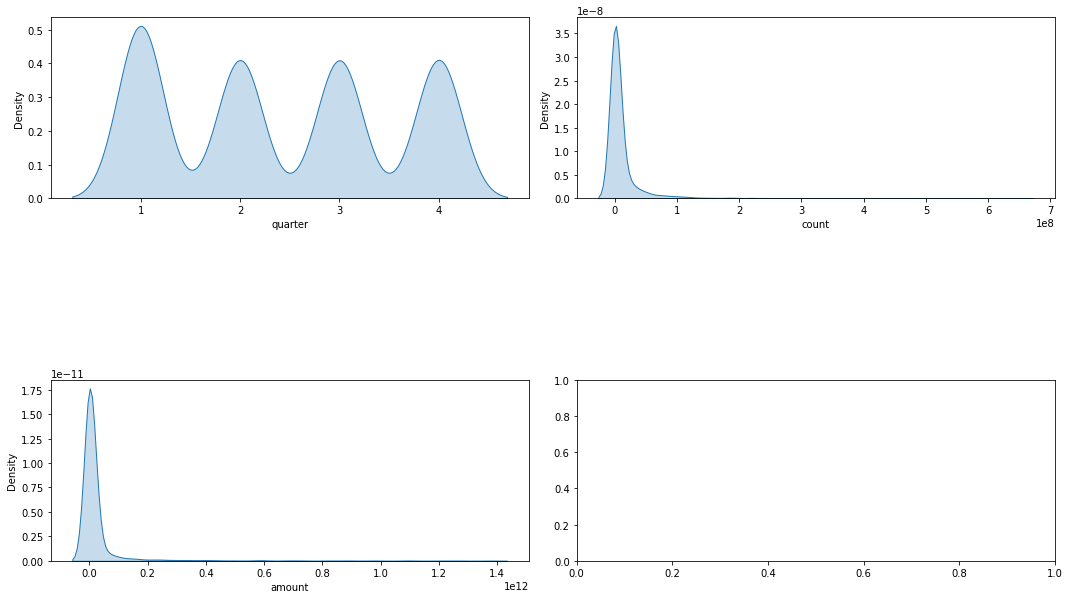

In [303]:
df= df_payment_type
num_cnames = df.select_dtypes(exclude=['object', 'datetime']).columns.to_list()

items_len = len(num_cnames)
rows = int(np.ceil(items_len/2))
cols = 2 if items_len >= 2 else items_len
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
fig.subplots_adjust(wspace=0.1, hspace=1)

for i, cname in enumerate(num_cnames):
    axis = axes[int(i//2), i % 2]
    sns.kdeplot(x=df[cname], shade=True, ax=axis)


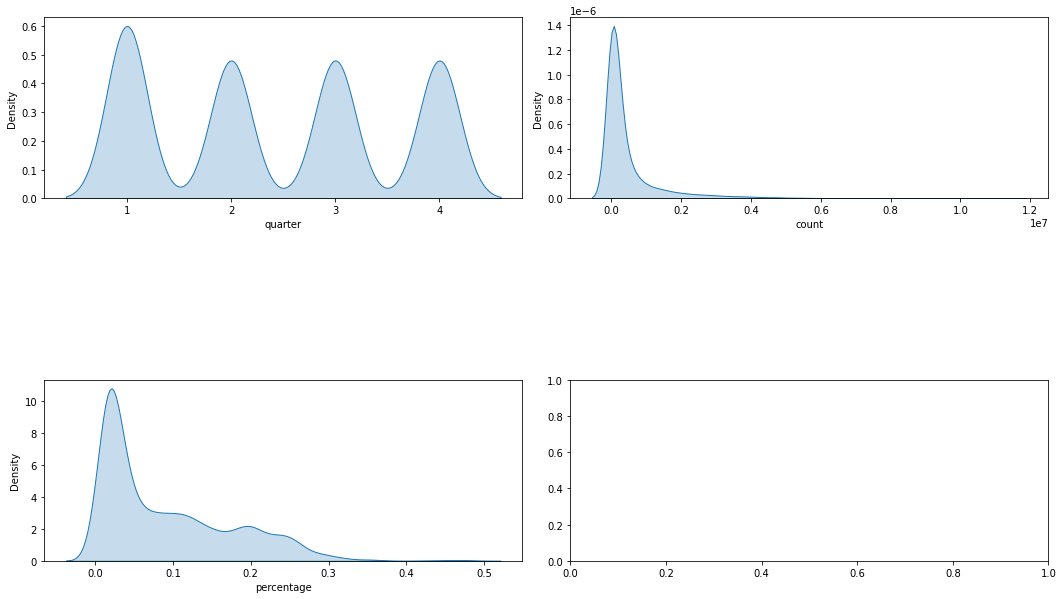

In [304]:
df = df_payment_device
num_cnames = df.select_dtypes(exclude=['object', 'datetime']).columns.to_list()

items_len = len(num_cnames)
rows = int(np.ceil(items_len/2))
cols = 2 if items_len >= 2 else items_len
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
fig.subplots_adjust(wspace=0.1, hspace=1)

for i, cname in enumerate(num_cnames):
    axis = axes[int(i//2), i % 2]
    sns.kdeplot(x=df[cname], shade=True, ax=axis)


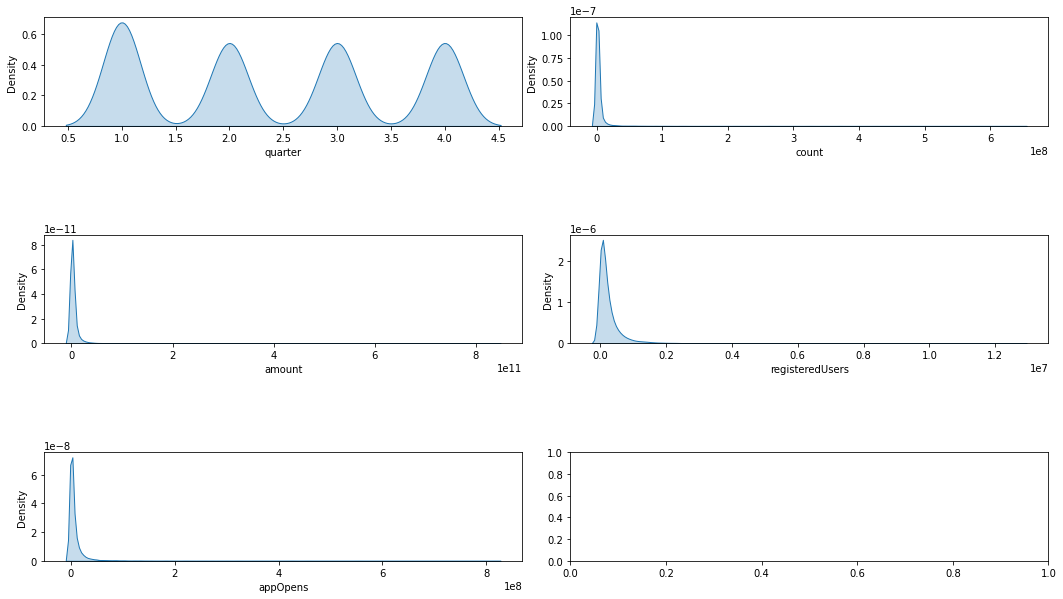

In [305]:
df = df_districts
num_cnames = df.select_dtypes(exclude=['object', 'datetime']).columns.to_list()

items_len = len(num_cnames)
rows = int(np.ceil(items_len/2))
cols = 2 if items_len >= 2 else items_len
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
fig.subplots_adjust(wspace=0.1, hspace=1)

for i, cname in enumerate(num_cnames):
    axis = axes[int(i//2), i % 2]
    sns.kdeplot(x=df[cname], shade=True, ax=axis)


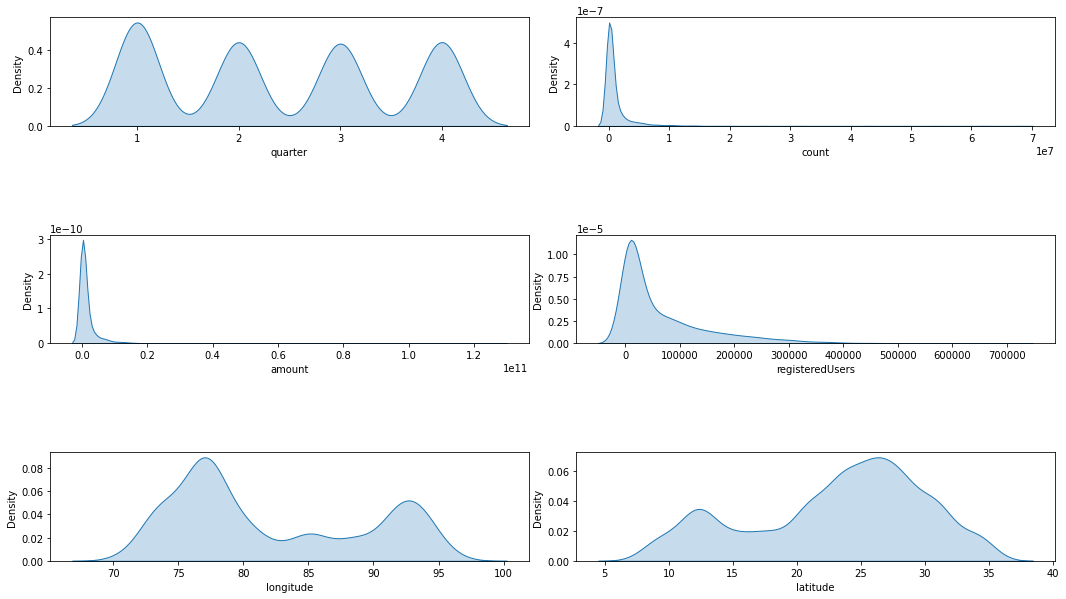

In [306]:
df = df_zips
num_cnames = df.select_dtypes(exclude=['object', 'datetime']).columns.to_list()

items_len = len(num_cnames)
rows = int(np.ceil(items_len/2))
cols = 2 if items_len >= 2 else items_len
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
fig.subplots_adjust(wspace=0.1, hspace=1)

for i, cname in enumerate(num_cnames):
    axis = axes[int(i//2), i % 2]
    sns.kdeplot(x=df[cname], shade=True, ax=axis)


    Modeling

In [307]:
df_districts.head()

,state,year,quarter,district,count,amount,registeredUsers,appOpens,date
0,Andaman and Nicobar,2019,3,north and middle andaman district,4049,1.148147e+07,2662,22064,2019-03-01
1,Andaman and Nicobar,2019,3,south andaman district,27421,9.102389e+07,20518,138190,2019-03-01
2,Andaman and Nicobar,2019,3,nicobars district,2300,1.156642e+07,751,10853,2019-03-01
3,Andaman and Nicobar,2019,2,north and middle andaman district,3371,8.612103e+06,2417,6118,2019-02-01
4,Andaman and Nicobar,2019,2,south andaman district,28490,1.025310e+08,18621,43569,2019-02-01


In [308]:
df_model =df_districts.copy(deep=True)

    Label Encoding state

In [309]:
state_number_map = \
    {'Telangana': 0,
     'Andaman and Nicobar': 35,
     'Andhra Pradesh': 28,
     'Arunachal Pradesh': 12,
     'Assam': 18,
     'Bihar': 10,
     'Chhattisgarh': 22,
     'Daman and Diu': 25,
     'Goa': 30,
     'Gujarat': 24,
     'Haryana': 6,
     'Himachal Pradesh': 2,
     'Jammu and Kashmir': 1,
     'Ladakh':1, # because in map coordinated we lack this
     'Jharkhand': 20,
     'Karnataka': 29,
     'Kerala': 32,
     'Lakshadweep': 31,
     'Madhya Pradesh': 23,
     'Maharashtra': 27,
     'Manipur': 14,
     'Chandigarh': 4,
     'Puducherry': 34,
     'Punjab': 3,
     'Rajasthan': 8,
     'Sikkim': 11,
     'Tamil Nadu': 33,
     'Tripura': 16,
     'Uttar Pradesh': 9,
     'Uttarakhand': 5,
     'West Bengal': 19,
     'Odisha': 21,
     'Meghalaya': 17,
     'Mizoram': 15,
     'Nagaland': 13,
     'Delhi': 7, }


In [310]:
df_model['state'] = df_model.replace({'state':state_number_map})['state'].astype('int16')
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12440 entries, 0 to 12439
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   state            12440 non-null  int16         
 1   year             12440 non-null  object        
 2   quarter          12440 non-null  int64         
 3   district         12440 non-null  object        
 4   count            12440 non-null  int64         
 5   amount           12440 non-null  float64       
 6   registeredUsers  12440 non-null  int64         
 7   appOpens         12440 non-null  int64         
 8   date             12440 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int16(1), int64(4), object(2)
memory usage: 1.1+ MB


In [311]:
df_model = df_model.groupby(['date','state']).sum().reset_index().set_index("date")
df_model.head()

,state,quarter,count,amount,registeredUsers,appOpens
date,,,,,,
2018-01-01,0,33,8522766,1.330820e+10,3315560,0
2018-01-01,1,24,947657,1.017904e+09,185209,0
2018-01-01,2,12,481918,6.287378e+08,227373,0
2018-01-01,3,22,1870433,2.780758e+09,847142,0
2018-01-01,4,1,381895,6.134354e+08,86268,0


In [312]:
df_model.drop(["quarter","appOpens"], axis=1, inplace=True)

In [313]:
df_model.head()

,state,count,amount,registeredUsers
date,,,,
2018-01-01,0,8522766,1.330820e+10,3315560
2018-01-01,1,947657,1.017904e+09,185209
2018-01-01,2,481918,6.287378e+08,227373
2018-01-01,3,1870433,2.780758e+09,847142
2018-01-01,4,381895,6.134354e+08,86268


In [314]:
pivot_date = df_model.index.min()
df_model["date_id"] = (df_model.index-pivot_date).days
df_model.head()


,state,count,amount,registeredUsers,date_id
date,,,,,
2018-01-01,0,8522766,1.330820e+10,3315560,0
2018-01-01,1,947657,1.017904e+09,185209,0
2018-01-01,2,481918,6.287378e+08,227373,0
2018-01-01,3,1870433,2.780758e+09,847142,0
2018-01-01,4,381895,6.134354e+08,86268,0


In [315]:
df_model = df_model.sort_index()

In [316]:
max_id = df_model['state'].unique().max()

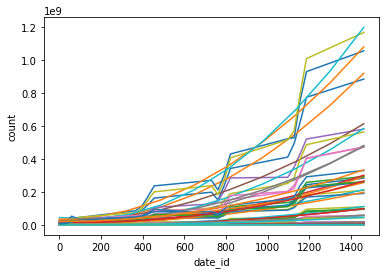

In [317]:
count_reg_models = list(range(max_id+1))
for state in state_number_map.values():
    df = df_model[df_model['state']==state]
    reg_poly_coeffs = np.polyfit(df["date_id"], df["count"], 2)
    reg_poly = np.poly1d(reg_poly_coeffs)
    count_reg_models[state] = reg_poly
    pts_x = np.linspace(df["date_id"][0], df["date_id"][-1],10)
    pts_y = reg_poly(pts_x)
    sns.lineplot(data=df, x="date_id", y="count")
    sns.lineplot(x= pts_x, y= pts_y)

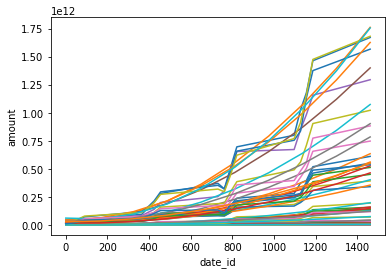

In [318]:
amount_reg_models = list(range(max_id+1))

for state in state_number_map.values():
    df = df_model[df_model['state']==state]
    reg_poly_coeffs = np.polyfit(df["date_id"], df["amount"], 2)
    reg_poly = np.poly1d(reg_poly_coeffs)
    amount_reg_models[state] = reg_poly
    pts_x = np.linspace(df["date_id"][0], df["date_id"][-1],10)
    pts_y = reg_poly(pts_x)
    sns.lineplot(data=df, x="date_id", y="amount")
    sns.lineplot(x= pts_x, y= pts_y)

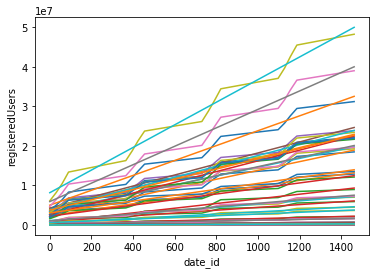

In [319]:
registration_reg_models = list(range(max_id+1))

for state in state_number_map.values():
    df = df_model[df_model['state']==state]
    reg_poly_coeffs = np.polyfit(df["date_id"], df["registeredUsers"], 1)
    reg_poly = np.poly1d(reg_poly_coeffs)
    registration_reg_models[state] = reg_poly
    pts_x = np.linspace(df["date_id"][0], df["date_id"][-1],10)
    pts_y = reg_poly(pts_x)
    sns.lineplot(data=df, x="date_id", y="registeredUsers")
    sns.lineplot(x= pts_x, y= pts_y)

In [320]:
# df_model.to_csv("model.csv")